In [1]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import time
import wandb
import random

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
data = pd.read_csv('/kaggle/input/doctor-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

labels = data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Define compute metrics for evaluation
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [8]:
# Define compute metrics for evaluation
def compute_metrics_eval(p):
    result = compute_metrics(p)
    
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )    
    return {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_micro': result['f1_micro'],
        'f1_macro': result['f1_macro'],
        'report': report
    }

# ACTIVE LEARNING LOOP

In [9]:
accuracies = []
f1_micros = []
f1_macros = []
sampling_dur = []
data_used = []

In [10]:
filename = 'dat-coreset'
epochs = 10
batch_size = 8
sequence_length = 256
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def coreset_sampling(model, X_pool, train_indices, remaining_indices, trials, n_samples=min_increment):
    start_time = time.time()
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    current_train_size = len(train_indices)

    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            with torch.no_grad():
                outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())

    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    # Use pairwise distances to compute a distance matrix for Coreset selection
    distance_matrix = pairwise_distances(embeddings)    
    selected_indices = [0]  # Start with an arbitrary first sample (e.g., index 0)
    
    # Calculate the minimum distance from selected points to all other points
    min_distances = distance_matrix[selected_indices].min(axis=0)
    sorted = np.argsort(min_distances)
    sorted = sorted[::-1]
    
    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
    num_of_candidates = len(candidates)

    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        selected_indices = sorted[:n_samples]
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        selected_indices = sorted[:num_of_candidates]
    else:
        selected_indices = sorted[:nearest_cp - current_train_size]

        temp = train_indices.copy()
        temp.extend(selected_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            '1-FR': [y_train[i][0] for i in temp],
            '2-GI': [y_train[i][1] for i in temp],
            '3-PI': [y_train[i][2] for i in temp],
            '4-DM': [y_train[i][3] for i in temp],
            '5-EDTRB': [y_train[i][4] for i in temp],
            '6-RE': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration in seconds

    print("Nearest checkpoint:", nearest_cp)
    print("Threshold:", threshold)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(selected_indices))
    print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed

    sampling_dur.append(duration)
    
    return [remaining_indices[i] for i in selected_indices]

In [12]:
def train_model(current_train_size, train_indices, trials, seed):
    model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p2',
        num_labels=len(labels),
        problem_type="multi_label_classification"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue
    
    # Create Dataset with current training data
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_dataset = DoctorAnswerDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{filename}-{trials+1}',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    trainer.compute_metrics = compute_metrics_eval
    eval_results = trainer.evaluate()
    print(f"Iteration {current_train_size}: Accuracy: {eval_results['eval_accuracy']}, F1 Micro: {eval_results['eval_f1_micro']}, F1 Macro: {eval_results['eval_f1_macro']}")
    print(eval_results['eval_report'])

    torch.save(model.state_dict(), f'{filename}-{trials+1}-model.pth')
    model.config.to_json_file(f'{filename}-{trials+1}-config.json')

    data_used.append(current_train_size)
    accuracies.append(eval_results['eval_accuracy'])
    f1_micros.append(eval_results['eval_f1_micro'])
    f1_macros.append(eval_results['eval_f1_macro'])
    
    return model, trainer

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [14]:
def active_learning(seed, i):
    accuracies.clear()
    f1_micros.clear()
    f1_macros.clear()
    sampling_dur.clear()
    data_used.clear()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model, trainer = train_model(current_train_size, train_indices, i, seed)
    
        # Perform query strategy to select new samples
        new_samples = coreset_sampling(
            model, 
            [X_train[i] for i in remaining_indices], 
            train_indices,
            remaining_indices,
            trials=i, 
        )
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model, trainer = train_model(current_train_size, train_indices, i, seed)
    
    end_time = time.time()
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [15]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241230_134352-b152zk4e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/dat-coreset-1
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.ai/nicost918-petra-christian-university/huggingface/runs/b152zk4e


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.445599,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.302310,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.249813,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.216971,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.195783,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.184268,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.178531,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.174130,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.171843,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.170646,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.031745147705077
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.008575916290283 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.293645,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.191430,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.163317,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.152961,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.148807,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.145152,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.142629,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.141722,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.141375,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.141233,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.581574249267579
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.6752207279205322 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.215710,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.159766,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.146199,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.143584,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.137076,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.135001,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.133944,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.130764,0.810000,0.964912,0.982143,0.973451,0.654117
9,No log,0.129883,0.810000,0.964912,0.982143,0.973451,0.654117
10,No log,0.129630,0.810000,0.964912,0.982143,0.973451,0.654117


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9734513274336283, F1 Macro: 0.6541174340169316
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.88723087310791
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.455396890640259 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.189919,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.149951,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.141860,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136377,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.139162,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.129265,0.810000,0.964912,0.982143,0.973451,0.654117
7,No log,0.131702,0.810000,0.964912,0.982143,0.973451,0.654117
8,No log,0.125754,0.810000,0.969543,0.974490,0.972010,0.652866
9,No log,0.127323,0.820000,0.969620,0.977041,0.973316,0.653859
10,No log,0.126041,0.810000,0.971939,0.971939,0.971939,0.652721


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.81, F1 Micro: 0.9734513274336283, F1 Macro: 0.6541174340169316
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.8357684135437
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.1883385181427 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.170943,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145751,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138088,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.131953,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.129640,0.810000,0.964912,0.982143,0.973451,0.654117
6,No log,0.122741,0.810000,0.964912,0.982143,0.973451,0.654117
7,No log,0.120768,0.810000,0.971939,0.971939,0.971939,0.652721
8,No log,0.119424,0.810000,0.971939,0.971939,0.971939,0.652721
9,No log,0.121377,0.820000,0.972010,0.974490,0.973248,0.653725
10,No log,0.120813,0.820000,0.972010,0.974490,0.973248,0.653725


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.81, F1 Micro: 0.9734513274336283, F1 Macro: 0.6541174340169316
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.93051872253418
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.0020945072174072 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.163754,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143821,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135182,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.129113,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.123518,0.810000,0.964912,0.982143,0.973451,0.654117
6,No log,0.119029,0.840000,0.974555,0.977041,0.975796,0.655587
7,No log,0.117369,0.820000,0.976864,0.969388,0.973111,0.653448
8,No log,0.115513,0.830000,0.976923,0.971939,0.974425,0.654466
9,No log,0.114653,0.840000,0.976982,0.974490,0.975734,0.655471
10,No log,0.114611,0.840000,0.976982,0.974490,0.975734,0.655471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.84, F1 Micro: 0.975796178343949, F1 Macro: 0.6555870600675632
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.575901985168457
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.831482172012329 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.157187,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143956,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.142266,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.133397,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.125484,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.120536,0.850000,0.977041,0.977041,0.977041,0.656466
7,No log,0.115384,0.830000,0.972152,0.979592,0.975858,0.655700
8,No log,0.115848,0.850000,0.977099,0.979592,0.978344,0.657449
9,No log,0.116020,0.840000,0.976982,0.974490,0.975734,0.655471
10,No log,0.115506,0.820000,0.976864,0.969388,0.973111,0.653448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.6574492574604868
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 14.381288528442383
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.6736207008361816 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153349,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.151351,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134127,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.130531,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.121755,0.810000,0.967254,0.979592,0.973384,0.653989
6,No log,0.121994,0.820000,0.969620,0.977041,0.973316,0.653859
7,No log,0.121622,0.800000,0.974293,0.966837,0.970551,0.651543
8,No log,0.115126,0.830000,0.974555,0.977041,0.975796,0.655587
9,No log,0.116474,0.810000,0.974359,0.969388,0.971867,0.652572
10,No log,0.115052,0.820000,0.974490,0.974490,0.974490,0.654593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.83, F1 Micro: 0.975796178343949, F1 Macro: 0.6555870600675632
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.729909706115723
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.5627472400665283 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150203,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142412,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.137235,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123153,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.113859,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.109928,0.870000,0.974811,0.987245,0.980989,0.768653
7,No log,0.104911,0.840000,0.977041,0.977041,0.977041,0.765577
8,No log,0.104446,0.850000,0.977099,0.979592,0.978344,0.766582
9,No log,0.103590,0.840000,0.977041,0.977041,0.977041,0.765577
10,No log,0.103602,0.840000,0.977041,0.977041,0.977041,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7686529640220748
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 13.741417121887208
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.4763319492340088 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149875,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147660,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131402,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.127233,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.113395,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.109013,0.830000,0.969773,0.982143,0.975919,0.655811
7,No log,0.105722,0.860000,0.972362,0.987245,0.979747,0.767783
8,No log,0.103781,0.840000,0.974619,0.979592,0.977099,0.765704
9,No log,0.103537,0.840000,0.977041,0.977041,0.977041,0.765577
10,No log,0.103456,0.850000,0.977099,0.979592,0.978344,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7677827476822451
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 13.698540782928466
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.3833119869232178 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152605,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137325,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131381,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.121862,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.109738,0.830000,0.972152,0.979592,0.975858,0.655700
6,No log,0.103697,0.870000,0.974811,0.987245,0.980989,0.799427
7,No log,0.101888,0.860000,0.974684,0.982143,0.978399,0.797450
8,No log,0.101246,0.870000,0.974811,0.987245,0.980989,0.799427
9,No log,0.099415,0.860000,0.974747,0.984694,0.979695,0.798444
10,No log,0.099451,0.860000,0.974747,0.984694,0.979695,0.798444


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 11.907139587402344
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.2731595039367676 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152350,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147009,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133671,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.122718,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.107960,0.840000,0.972222,0.982143,0.977157,0.656672
6,No log,0.100847,0.850000,0.974684,0.982143,0.978399,0.766698
7,No log,0.098032,0.870000,0.974811,0.987245,0.980989,0.799427
8,No log,0.098611,0.860000,0.974747,0.984694,0.979695,0.798444
9,No log,0.096461,0.860000,0.974747,0.984694,0.979695,0.798444
10,No log,0.096672,0.860000,0.974747,0.984694,0.979695,0.798444


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 11.918279647827148
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.177694320678711 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.157722,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145897,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.139273,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.130093,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.115198,0.820000,0.964912,0.982143,0.973451,0.654117
6,No log,0.107239,0.840000,0.972222,0.982143,0.977157,0.797450
7,No log,0.105822,0.850000,0.972292,0.984694,0.978454,0.780587
8,No log,0.102167,0.850000,0.972292,0.984694,0.978454,0.780587
9,No log,0.101173,0.820000,0.969697,0.979592,0.974619,0.764699
10,No log,0.101092,0.830000,0.972152,0.979592,0.975858,0.778588


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.824026489257813
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.2395927906036377 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150497,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140318,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133039,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.117806,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.107128,0.840000,0.974619,0.979592,0.977099,0.722254
6,No log,0.108497,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.106829,0.840000,0.974555,0.977041,0.975796,0.778448
8,No log,0.101791,0.840000,0.977041,0.977041,0.977041,0.796305
9,No log,0.102486,0.850000,0.974619,0.979592,0.977099,0.779466
10,No log,0.102100,0.850000,0.972222,0.982143,0.977157,0.779593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.85, F1 Micro: 0.9771573604060914, F1 Macro: 0.7795931906724634
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 11.363000011444091
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 0.9989566802978516 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145566,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135635,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.136678,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123559,0.810000,0.967254,0.979592,0.973384,0.653989
5,No log,0.109667,0.840000,0.974619,0.979592,0.977099,0.796445
6,No log,0.117880,0.810000,0.979221,0.961735,0.970399,0.773863
7,No log,0.114741,0.810000,0.971939,0.971939,0.971939,0.762489
8,No log,0.106434,0.830000,0.967337,0.982143,0.974684,0.754593
9,No log,0.104545,0.840000,0.969773,0.982143,0.975919,0.765704
10,No log,0.103560,0.850000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7974503335296063
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 11.03220739364624
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 0.9788994789123535 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155840,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140508,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130332,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.111130,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.103664,0.840000,0.974619,0.979592,0.977099,0.656570
6,No log,0.104932,0.820000,0.969620,0.977041,0.973316,0.763683
7,No log,0.101200,0.840000,0.969773,0.982143,0.975919,0.765704
8,No log,0.100852,0.810000,0.969543,0.974490,0.972010,0.762655
9,No log,0.099536,0.830000,0.969697,0.979592,0.974619,0.764699
10,No log,0.102066,0.830000,0.969697,0.979592,0.974619,0.764699


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.656569886469384
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.769620895385742
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.9051697254180908 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143070,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139099,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122484,0.820000,0.967337,0.982143,0.974684,0.654960
4,No log,0.112156,0.810000,0.974425,0.971939,0.973180,0.653588
5,No log,0.112530,0.870000,0.972362,0.987245,0.979747,0.781570
6,No log,0.111063,0.820000,0.969620,0.977041,0.973316,0.763683
7,No log,0.111820,0.800000,0.969466,0.971939,0.970701,0.761615
8,No log,0.106853,0.830000,0.969697,0.979592,0.974619,0.764699
9,No log,0.109697,0.810000,0.969543,0.974490,0.972010,0.762655
10,No log,0.107159,0.830000,0.969697,0.979592,0.974619,0.764699


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.87, F1 Micro: 0.979746835443038, F1 Macro: 0.781569886469384
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.444085311889648
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.8292245864868164 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145865,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137432,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124549,0.820000,0.967337,0.982143,0.974684,0.654960
4,No log,0.109942,0.820000,0.974490,0.974490,0.974490,0.654593
5,No log,0.103591,0.870000,0.974811,0.987245,0.980989,0.799427
6,No log,0.111649,0.830000,0.969697,0.979592,0.974619,0.764699
7,No log,0.104590,0.840000,0.972152,0.979592,0.975858,0.778588
8,No log,0.105383,0.850000,0.972222,0.982143,0.977157,0.779593
9,No log,0.108002,0.850000,0.972222,0.982143,0.977157,0.779593
10,No log,0.105921,0.840000,0.972152,0.979592,0.975858,0.778588


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.501352500915528
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.8062701225280762 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146185,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133102,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125036,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.112125,0.800000,0.976804,0.966837,0.971795,0.652419
5,No log,0.104050,0.810000,0.974425,0.971939,0.973180,0.762655
6,No log,0.104026,0.820000,0.972010,0.974490,0.973248,0.747810
7,No log,0.105268,0.850000,0.967419,0.984694,0.975980,0.755587
8,No log,0.108602,0.790000,0.964646,0.974490,0.969543,0.742453
9,No log,0.104521,0.830000,0.964912,0.982143,0.973451,0.745502
10,No log,0.102187,0.830000,0.969697,0.979592,0.974619,0.764699


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.85, F1 Micro: 0.9759797724399494, F1 Macro: 0.7555870600675632
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 10.51802043914795
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.6857354640960693 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147844,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138962,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128556,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115039,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.115065,0.860000,0.972292,0.984694,0.978454,0.780587
6,No log,0.116385,0.800000,0.964736,0.977041,0.970849,0.754983
7,No log,0.103209,0.830000,0.972152,0.979592,0.975858,0.786782
8,No log,0.102500,0.850000,0.972222,0.982143,0.977157,0.766582
9,No log,0.100978,0.850000,0.972222,0.982143,0.977157,0.766582
10,No log,0.102501,0.840000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 10.126615047454834
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.605402946472168 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147435,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136252,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122571,0.810000,0.974359,0.969388,0.971867,0.652572
4,No log,0.106432,0.850000,0.977099,0.979592,0.978344,0.723133
5,No log,0.109440,0.820000,0.971939,0.971939,0.971939,0.762489
6,No log,0.110945,0.800000,0.969466,0.971939,0.970701,0.751378
7,No log,0.109520,0.800000,0.971795,0.966837,0.969309,0.760371
8,No log,0.107885,0.820000,0.972010,0.974490,0.973248,0.763530
9,No log,0.104291,0.850000,0.972222,0.982143,0.977157,0.766582
10,No log,0.105138,0.850000,0.972222,0.982143,0.977157,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.7231325165151601
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.634084701538086
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.520655632019043 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140280,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132228,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128954,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.108418,0.810000,0.976804,0.966837,0.971795,0.652419
5,No log,0.106648,0.840000,0.977041,0.977041,0.977041,0.796305
6,No log,0.114652,0.820000,0.969543,0.974490,0.972010,0.752419
7,No log,0.111656,0.840000,0.974555,0.977041,0.975796,0.778448
8,No log,0.107417,0.840000,0.974555,0.977041,0.975796,0.778448
9,No log,0.106815,0.850000,0.974619,0.979592,0.977099,0.779466
10,No log,0.106172,0.850000,0.972222,0.982143,0.977157,0.779593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9771573604060914, F1 Macro: 0.7795931906724634
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.916854190826417
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.4268224239349365 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145187,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128951,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117574,0.810000,0.967172,0.977041,0.972081,0.653009
4,No log,0.107328,0.820000,0.967254,0.979592,0.973384,0.653989
5,No log,0.104980,0.840000,0.974619,0.979592,0.977099,0.796445
6,No log,0.102532,0.830000,0.979381,0.969388,0.974359,0.763374
7,No log,0.103861,0.830000,0.969697,0.979592,0.974619,0.754466
8,No log,0.101804,0.840000,0.974619,0.979592,0.977099,0.779466
9,No log,0.103808,0.830000,0.972152,0.979592,0.975858,0.765577
10,No log,0.102658,0.830000,0.974555,0.977041,0.975796,0.749704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.7964452339718501
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.210268592834472
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.3676717281341553 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142585,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132407,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117878,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.106888,0.810000,0.976864,0.969388,0.973111,0.653448
5,No log,0.110509,0.810000,0.976804,0.966837,0.971795,0.792117
6,No log,0.109592,0.820000,0.974425,0.971939,0.973180,0.776378
7,No log,0.112648,0.830000,0.967254,0.979592,0.973384,0.745375
8,No log,0.109887,0.850000,0.977099,0.979592,0.978344,0.797323
9,No log,0.109449,0.830000,0.972081,0.977041,0.974555,0.764559
10,0.102800,0.107922,0.850000,0.977099,0.979592,0.978344,0.797323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.7973226522221498
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392

Total sampling time: 31.07 seconds
Total runtime: 2735.215845823288 seconds


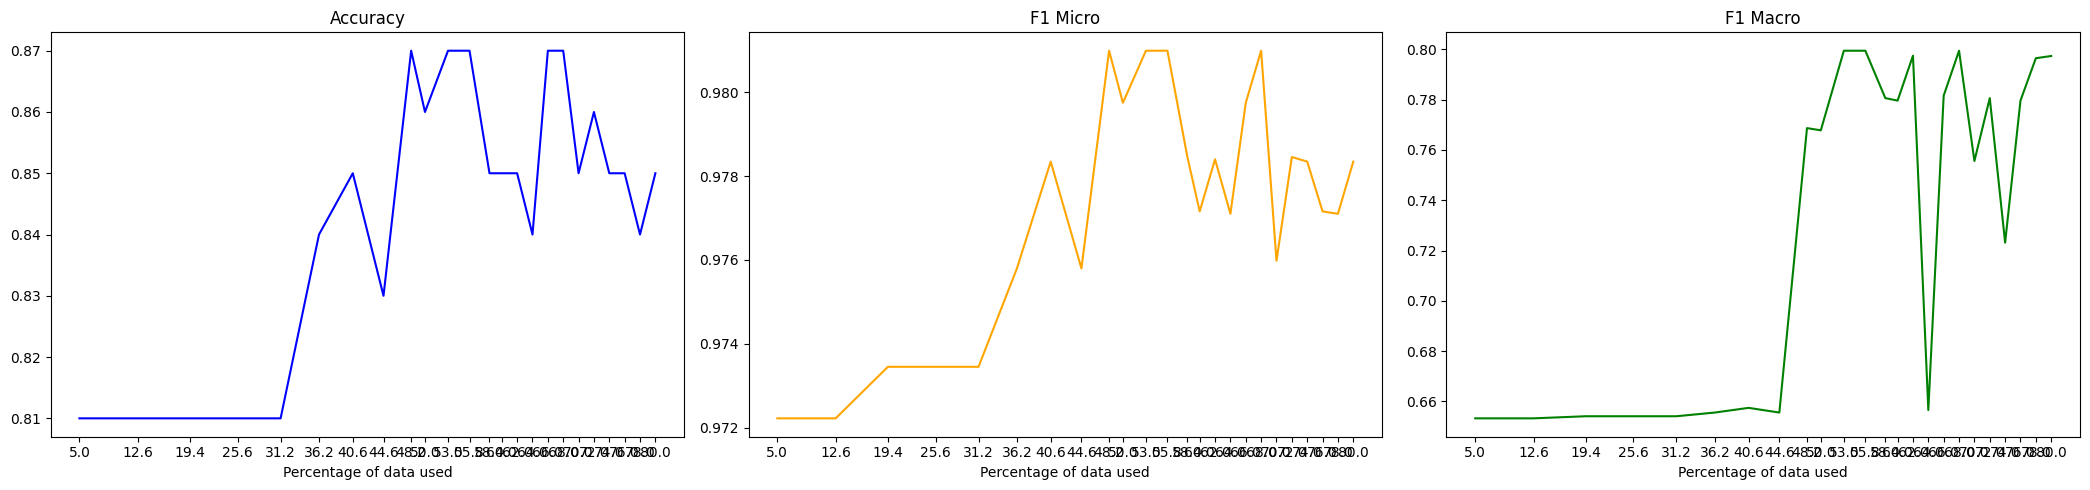

In [16]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.427260,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.301268,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.235869,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.204235,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.186607,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.177279,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.172513,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.168742,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.166898,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.166246,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.89074420928955
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 2.9878969192504883 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.255966,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.182321,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.159202,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.152006,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.146343,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.142847,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.141522,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.139791,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.139024,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.138801,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.620690727233887
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7601561546325684 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.195902,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.155310,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143302,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.141091,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.137565,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.133535,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.130297,0.820000,0.964912,0.982143,0.973451,0.654117
8,No log,0.129862,0.830000,0.967337,0.982143,0.974684,0.654960
9,No log,0.126465,0.830000,0.967337,0.982143,0.974684,0.654960
10,No log,0.126049,0.830000,0.967337,0.982143,0.974684,0.654960


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.318157196044922
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.543733596801758 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.192463,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.150238,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.141257,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.140572,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.132319,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.130077,0.830000,0.967337,0.982143,0.974684,0.654960
7,No log,0.134313,0.810000,0.967172,0.977041,0.972081,0.653009
8,No log,0.131159,0.790000,0.969388,0.969388,0.969388,0.650848
9,No log,0.126508,0.810000,0.967172,0.977041,0.972081,0.653009
10,No log,0.127740,0.800000,0.967089,0.974490,0.970775,0.652017


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.071960735321046
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.3046534061431885 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.165295,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147962,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138386,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.137800,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.130169,0.830000,0.967337,0.982143,0.974684,0.654960
6,No log,0.128713,0.810000,0.967172,0.977041,0.972081,0.653009
7,No log,0.126221,0.820000,0.967254,0.979592,0.973384,0.653989
8,No log,0.129694,0.790000,0.976744,0.964286,0.970475,0.651378
9,No log,0.126766,0.800000,0.971867,0.969388,0.970626,0.651705
10,No log,0.128270,0.790000,0.976744,0.964286,0.970475,0.651378


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.468129730224609
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.081681728363037 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.161438,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141702,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134647,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.129473,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.127931,0.820000,0.967254,0.979592,0.973384,0.653989
6,No log,0.128170,0.830000,0.974490,0.974490,0.974490,0.654593
7,No log,0.120883,0.810000,0.974425,0.971939,0.973180,0.653588
8,No log,0.127515,0.780000,0.979167,0.959184,0.969072,0.650143
9,No log,0.122807,0.790000,0.971867,0.969388,0.970626,0.651705
10,No log,0.125389,0.780000,0.979167,0.959184,0.969072,0.650143


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.83, F1 Micro: 0.9744897959183674, F1 Macro: 0.6545931906724635
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.62800121307373
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.8945989608764648 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154771,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138737,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133150,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.124891,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.124346,0.830000,0.969697,0.979592,0.974619,0.654840
6,No log,0.123214,0.830000,0.967337,0.982143,0.974684,0.720656
7,No log,0.127222,0.770000,0.976623,0.959184,0.967825,0.714849
8,No log,0.123666,0.780000,0.976684,0.961735,0.969152,0.715927
9,No log,0.125381,0.780000,0.979167,0.959184,0.969072,0.715731
10,No log,0.124864,0.780000,0.979167,0.959184,0.969072,0.715731


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.31258316040039
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7592556476593018 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152635,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140886,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133980,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.125194,0.810000,0.967172,0.977041,0.972081,0.653009
5,No log,0.119428,0.830000,0.967337,0.982143,0.974684,0.654960
6,No log,0.115549,0.820000,0.972081,0.977041,0.974555,0.654718
7,No log,0.115770,0.830000,0.972152,0.979592,0.975858,0.721385
8,No log,0.116951,0.820000,0.969697,0.979592,0.974619,0.763977
9,No log,0.117977,0.790000,0.974293,0.966837,0.970551,0.760563
10,No log,0.118321,0.800000,0.976804,0.966837,0.971795,0.761436


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.7213847012841987
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.875654411315917
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.6315765380859375 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152875,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139782,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129395,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.122709,0.810000,0.969543,0.974490,0.972010,0.652866
5,No log,0.113820,0.840000,0.972222,0.982143,0.977157,0.722367
6,No log,0.115050,0.840000,0.979487,0.974490,0.976982,0.722020
7,No log,0.110941,0.830000,0.969773,0.982143,0.975919,0.764970
8,No log,0.114286,0.800000,0.979275,0.964286,0.971722,0.761254
9,No log,0.111669,0.810000,0.979328,0.966837,0.973042,0.762320
10,No log,0.109089,0.840000,0.977041,0.977041,0.977041,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.7223668989514792
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.661133003234864
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.5003304481506348 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.158569,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.146690,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129914,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.118740,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.114044,0.830000,0.969773,0.982143,0.975919,0.655811
6,No log,0.113365,0.840000,0.974619,0.979592,0.977099,0.722254
7,No log,0.109873,0.840000,0.974619,0.979592,0.977099,0.722254
8,No log,0.111799,0.820000,0.976923,0.971939,0.974425,0.763530
9,No log,0.109951,0.810000,0.976864,0.969388,0.973111,0.762489
10,No log,0.110362,0.830000,0.976982,0.974490,0.975734,0.795276


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.7222537267342298
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 11.164669036865234
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4404296875 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147092,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139437,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127138,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115251,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.108847,0.830000,0.972152,0.979592,0.975858,0.655700
6,No log,0.107875,0.820000,0.972081,0.977041,0.974555,0.720392
7,No log,0.109479,0.820000,0.981865,0.966837,0.974293,0.763215
8,No log,0.107476,0.820000,0.972081,0.977041,0.974555,0.763832
9,No log,0.111114,0.810000,0.981818,0.964286,0.972973,0.762147
10,No log,0.107007,0.830000,0.974555,0.977041,0.975796,0.764699


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.828406524658204
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.2962400913238525 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155513,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136240,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132887,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.118743,0.820000,0.969697,0.979592,0.974619,0.654840
5,No log,0.110325,0.840000,0.974619,0.979592,0.977099,0.722254
6,No log,0.108793,0.820000,0.969697,0.979592,0.974619,0.720525
7,No log,0.107488,0.830000,0.969773,0.982143,0.975919,0.764970
8,No log,0.108775,0.800000,0.976804,0.966837,0.971795,0.761436
9,No log,0.108349,0.800000,0.976804,0.966837,0.971795,0.761436
10,No log,0.107127,0.820000,0.976923,0.971939,0.974425,0.763530


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.7222537267342298
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.567947387695312
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.2301290035247803 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155621,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135204,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130266,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.116364,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.108584,0.840000,0.974619,0.979592,0.977099,0.656570
6,No log,0.108913,0.840000,0.974619,0.979592,0.977099,0.722254
7,No log,0.107996,0.850000,0.974684,0.982143,0.978399,0.766698
8,No log,0.107596,0.850000,0.977099,0.979592,0.978344,0.766582
9,No log,0.108436,0.830000,0.981959,0.971939,0.976923,0.765312
10,No log,0.106956,0.840000,0.974555,0.977041,0.975796,0.749704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7666981711786742
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 11.770941352844238
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.1730241775512695 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145782,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137605,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125074,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.118200,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.109227,0.840000,0.977041,0.977041,0.977041,0.722138
6,No log,0.105816,0.860000,0.977157,0.982143,0.979644,0.767577
7,No log,0.108434,0.840000,0.977041,0.977041,0.977041,0.765577
8,No log,0.104517,0.840000,0.979487,0.974490,0.976982,0.765446
9,No log,0.104290,0.850000,0.977099,0.979592,0.978344,0.797323
10,No log,0.104563,0.840000,0.979487,0.974490,0.976982,0.796162


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9796437659033078, F1 Macro: 0.7675769609596045
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 11.097467422485352
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.1213767528533936 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149168,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134267,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123505,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.111674,0.840000,0.969773,0.982143,0.975919,0.721507
5,No log,0.105820,0.830000,0.974555,0.977041,0.975796,0.721260
6,No log,0.101421,0.850000,0.974684,0.982143,0.978399,0.766698
7,No log,0.108815,0.840000,0.981959,0.971939,0.976923,0.779064
8,No log,0.102602,0.860000,0.974684,0.982143,0.978399,0.780471
9,No log,0.104075,0.850000,0.974619,0.979592,0.977099,0.779466
10,No log,0.103579,0.850000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7666981711786742
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 11.050834655761719
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.0127243995666504 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140892,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140220,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129863,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.112022,0.830000,0.969773,0.982143,0.975919,0.721507
5,No log,0.102983,0.840000,0.974619,0.979592,0.977099,0.722254
6,No log,0.100376,0.850000,0.977099,0.979592,0.978344,0.723133
7,No log,0.099355,0.860000,0.972292,0.984694,0.978454,0.780587
8,No log,0.098922,0.860000,0.974747,0.984694,0.979695,0.798444
9,No log,0.098649,0.870000,0.974747,0.984694,0.979695,0.781466
10,No log,0.097177,0.870000,0.977215,0.984694,0.980940,0.799323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.87, F1 Micro: 0.9809402795425667, F1 Macro: 0.7993229927056363
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.922842025756836
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.9387338161468506 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152329,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137285,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129763,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.108728,0.840000,0.969773,0.982143,0.975919,0.655811
5,No log,0.105305,0.840000,0.972222,0.982143,0.977157,0.765829
6,No log,0.100363,0.850000,0.979540,0.977041,0.978289,0.797192
7,No log,0.097284,0.860000,0.977157,0.982143,0.979644,0.798328
8,No log,0.100742,0.840000,0.976982,0.974490,0.975734,0.778305
9,No log,0.096399,0.850000,0.977099,0.979592,0.978344,0.797323
10,No log,0.096083,0.850000,0.977099,0.979592,0.978344,0.797323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.86, F1 Micro: 0.9796437659033078, F1 Macro: 0.7983284731432249
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.813395595550537
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.8734562397003174 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141553,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133201,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121721,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.108777,0.840000,0.972222,0.982143,0.977157,0.656672
5,No log,0.107815,0.820000,0.974490,0.974490,0.974490,0.720255
6,No log,0.100871,0.850000,0.974684,0.982143,0.978399,0.797450
7,No log,0.103931,0.840000,0.977041,0.977041,0.977041,0.796305
8,No log,0.101463,0.860000,0.974747,0.984694,0.979695,0.798444
9,No log,0.103252,0.860000,0.972292,0.984694,0.978454,0.780587
10,No log,0.101996,0.840000,0.974619,0.979592,0.977099,0.796445


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.965096855163575
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 6.43100643157959 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143412,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132907,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118390,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.108256,0.820000,0.969697,0.979592,0.974619,0.654840
5,No log,0.111754,0.830000,0.974555,0.977041,0.975796,0.764699
6,No log,0.102928,0.840000,0.977041,0.977041,0.977041,0.765577
7,No log,0.104310,0.830000,0.974555,0.977041,0.975796,0.764699
8,No log,0.104281,0.850000,0.972222,0.982143,0.977157,0.779593
9,No log,0.104283,0.840000,0.969773,0.982143,0.975919,0.778725
10,No log,0.101884,0.850000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7974503335296063
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 10.597622966766357
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7273588180541992 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140323,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133307,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.140246,0.800000,0.981723,0.959184,0.970323,0.651036
4,No log,0.104927,0.840000,0.972222,0.982143,0.977157,0.656672
5,No log,0.101439,0.820000,0.976982,0.974490,0.975734,0.721132
6,No log,0.099518,0.840000,0.974619,0.979592,0.977099,0.765704
7,No log,0.098177,0.850000,0.974684,0.982143,0.978399,0.797450
8,No log,0.098602,0.820000,0.972081,0.977041,0.974555,0.720392
9,No log,0.100290,0.840000,0.972222,0.982143,0.977157,0.796582
10,No log,0.099194,0.850000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7974503335296063
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 10.650495624542236
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6252021789550781 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142301,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129596,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.114527,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.112343,0.840000,0.967419,0.984694,0.975980,0.721626
5,No log,0.105154,0.820000,0.981912,0.969388,0.975610,0.794961
6,No log,0.105701,0.840000,0.974555,0.977041,0.975796,0.778448
7,No log,0.104728,0.830000,0.972081,0.977041,0.974555,0.764559
8,No log,0.104257,0.840000,0.972152,0.979592,0.975858,0.778588
9,No log,0.101287,0.840000,0.969773,0.982143,0.975919,0.778725
10,No log,0.101563,0.840000,0.969773,0.982143,0.975919,0.778725


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.84, F1 Micro: 0.9759797724399494, F1 Macro: 0.7216262471779186
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.44123296737671
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5182316303253174 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140708,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128916,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112968,0.830000,0.969697,0.979592,0.974619,0.654840
4,No log,0.106035,0.830000,0.974555,0.977041,0.975796,0.721260
5,No log,0.103966,0.830000,0.972081,0.977041,0.974555,0.777572
6,No log,0.107656,0.860000,0.969925,0.987245,0.978508,0.767681
7,No log,0.105316,0.850000,0.972222,0.982143,0.977157,0.766582
8,No log,0.100045,0.870000,0.974747,0.984694,0.979695,0.781466
9,No log,0.099466,0.860000,0.972292,0.984694,0.978454,0.767577
10,No log,0.097899,0.850000,0.969849,0.984694,0.977215,0.766698


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.851228809356689
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.43076443672180176 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150282,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133739,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118732,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.105612,0.840000,0.977041,0.977041,0.977041,0.656466
5,No log,0.106134,0.860000,0.974747,0.984694,0.979695,0.798444
6,No log,0.103401,0.830000,0.974490,0.974490,0.974490,0.777419
7,No log,0.099532,0.860000,0.974684,0.982143,0.978399,0.780471
8,No log,0.098111,0.840000,0.974555,0.977041,0.975796,0.778448
9,No log,0.096608,0.870000,0.974747,0.984694,0.979695,0.781466
10,No log,0.097970,0.880000,0.974811,0.987245,0.980989,0.782449


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.88, F1 Micro: 0.9809885931558936, F1 Macro: 0.7824492574604868
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.223261260986328
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.3861429691314697 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149158,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136010,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113640,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.108524,0.840000,0.972222,0.982143,0.977157,0.722367
5,No log,0.104723,0.860000,0.977157,0.982143,0.979644,0.798328
6,No log,0.105053,0.830000,0.981912,0.969388,0.975610,0.778009
7,No log,0.100566,0.880000,0.974811,0.987245,0.980989,0.782449
8,No log,0.096467,0.870000,0.974747,0.984694,0.979695,0.781466
9,No log,0.095422,0.850000,0.974684,0.982143,0.978399,0.798328
10,0.100700,0.094994,0.860000,0.977157,0.982143,0.979644,0.798328


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.88, F1 Micro: 0.9809885931558936, F1 Macro: 0.7824492574604868
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392

Total sampling time: 37.67 seconds
Total runtime: 2625.487236738205 seconds


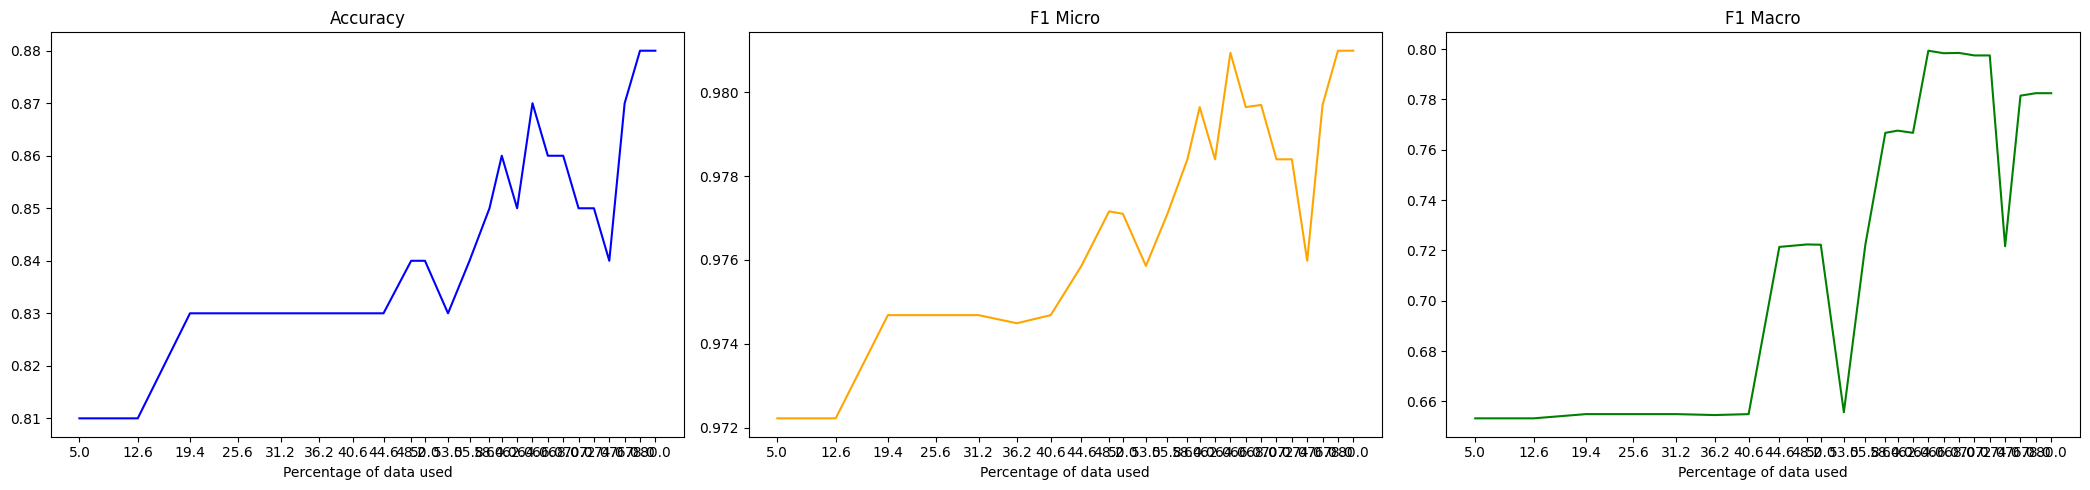

In [17]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.397611,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.288708,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.231498,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.205215,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.187409,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.178176,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.173865,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.169992,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.167555,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.166610,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.151445007324218
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 2.9662282466888428 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.279242,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.194703,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.165359,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.157922,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.149704,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.144253,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.143834,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.139933,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.138836,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.138408,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.322051429748536
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7429721355438232 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.201524,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.158014,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.145836,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.142289,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.137224,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.134564,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.130503,0.830000,0.972081,0.977041,0.974555,0.654718
8,No log,0.128706,0.820000,0.969697,0.979592,0.974619,0.654840
9,No log,0.128585,0.820000,0.969697,0.979592,0.974619,0.654840
10,No log,0.129824,0.820000,0.972010,0.974490,0.973248,0.653725


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.82, F1 Micro: 0.9746192893401016, F1 Macro: 0.6548401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.738082313537598
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.504805326461792 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.189778,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.153272,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143782,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.138792,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.134753,0.810000,0.964912,0.982143,0.973451,0.654117
6,No log,0.129000,0.820000,0.967337,0.982143,0.974684,0.654960
7,No log,0.129958,0.820000,0.976864,0.969388,0.973111,0.653448
8,No log,0.124149,0.820000,0.972081,0.977041,0.974555,0.654718
9,No log,0.124319,0.810000,0.976804,0.966837,0.971795,0.652419
10,No log,0.123093,0.830000,0.972152,0.979592,0.975858,0.655700


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.435103416442871
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.2531909942626953 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.169678,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145456,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.136318,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.133625,0.810000,0.967254,0.979592,0.973384,0.653989
5,No log,0.125213,0.810000,0.969620,0.977041,0.973316,0.653859
6,No log,0.122731,0.820000,0.969697,0.979592,0.974619,0.654840
7,No log,0.125715,0.810000,0.979275,0.964286,0.971722,0.652263
8,No log,0.120166,0.810000,0.976864,0.969388,0.973111,0.653448
9,No log,0.121271,0.800000,0.976804,0.966837,0.971795,0.652419
10,No log,0.120055,0.810000,0.976864,0.969388,0.973111,0.653448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.82, F1 Micro: 0.9746192893401016, F1 Macro: 0.6548401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.06707010269165
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.059225559234619 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.170154,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145547,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.136315,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.130561,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.126499,0.810000,0.967254,0.979592,0.973384,0.653989
6,No log,0.124326,0.810000,0.972010,0.974490,0.973248,0.653725
7,No log,0.123689,0.810000,0.976864,0.969388,0.973111,0.653448
8,No log,0.121983,0.810000,0.974425,0.971939,0.973180,0.719238
9,No log,0.122605,0.810000,0.976864,0.969388,0.973111,0.719086
10,No log,0.122431,0.810000,0.976864,0.969388,0.973111,0.719086


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.81, F1 Micro: 0.973384030418251, F1 Macro: 0.6539894371676231
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.747343444824219
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.8829751014709473 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.161367,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141301,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138956,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.133721,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.132480,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.123081,0.820000,0.969697,0.979592,0.974619,0.654840
7,No log,0.115436,0.840000,0.974619,0.979592,0.977099,0.722254
8,No log,0.114414,0.850000,0.974684,0.982143,0.978399,0.766698
9,No log,0.113951,0.850000,0.974684,0.982143,0.978399,0.766698
10,No log,0.113667,0.830000,0.974555,0.977041,0.975796,0.764699


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7666981711786742
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.434404182434083
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7461731433868408 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.163806,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147144,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130913,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.131889,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.120232,0.830000,0.974555,0.977041,0.975796,0.655587
6,No log,0.114145,0.840000,0.974619,0.979592,0.977099,0.796445
7,No log,0.112618,0.860000,0.972362,0.987245,0.979747,0.798557
8,No log,0.108352,0.860000,0.972362,0.987245,0.979747,0.798557
9,No log,0.107714,0.830000,0.974555,0.977041,0.975796,0.795429
10,No log,0.106776,0.850000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7985573751419555
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.254661560058594
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.6586833000183105 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151741,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143508,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134270,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.122500,0.820000,0.969697,0.979592,0.974619,0.654840
5,No log,0.116256,0.840000,0.974619,0.979592,0.977099,0.722254
6,No log,0.107712,0.860000,0.972362,0.987245,0.979747,0.798557
7,No log,0.103917,0.870000,0.974811,0.987245,0.980989,0.799427
8,No log,0.103368,0.860000,0.974747,0.984694,0.979695,0.798444
9,No log,0.104435,0.850000,0.977099,0.979592,0.978344,0.797323
10,No log,0.103247,0.860000,0.974747,0.984694,0.979695,0.798444


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.311437034606934
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.5256097316741943 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155615,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.148299,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.136462,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.128763,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.118414,0.840000,0.977041,0.977041,0.977041,0.656466
6,No log,0.106249,0.870000,0.974811,0.987245,0.980989,0.799427
7,No log,0.105542,0.830000,0.974555,0.977041,0.975796,0.795429
8,No log,0.105267,0.840000,0.972152,0.979592,0.975858,0.778588
9,No log,0.103020,0.840000,0.974619,0.979592,0.977099,0.796445
10,No log,0.103974,0.840000,0.977041,0.977041,0.977041,0.796305


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.710770988464356
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4765212535858154 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149126,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142177,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127127,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.113813,0.860000,0.972362,0.987245,0.979747,0.798557
5,No log,0.114773,0.820000,0.962687,0.987245,0.974811,0.754840
6,No log,0.106539,0.840000,0.967500,0.987245,0.977273,0.779840
7,No log,0.104199,0.840000,0.972222,0.982143,0.977157,0.779593
8,No log,0.106824,0.820000,0.969697,0.979592,0.974619,0.764699
9,No log,0.103830,0.820000,0.969697,0.979592,0.974619,0.764699
10,No log,0.105896,0.820000,0.969697,0.979592,0.974619,0.764699


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7985573751419555
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.183325576782227
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.2819583415985107 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151839,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140002,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124981,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.120607,0.820000,0.974490,0.974490,0.974490,0.654593
5,No log,0.114938,0.840000,0.967500,0.987245,0.977273,0.779840
6,No log,0.112979,0.830000,0.967419,0.984694,0.975980,0.775805
7,No log,0.107774,0.800000,0.969543,0.974490,0.972010,0.776543
8,No log,0.105899,0.830000,0.972152,0.979592,0.975858,0.796445
9,No log,0.105635,0.830000,0.972152,0.979592,0.975858,0.796445
10,No log,0.106538,0.820000,0.974490,0.974490,0.974490,0.795276


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.84, F1 Micro: 0.9772727272727273, F1 Macro: 0.7798401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.80453109741211
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.2121870517730713 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146799,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137068,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125910,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.115337,0.840000,0.967500,0.987245,0.977273,0.779840
5,No log,0.113935,0.810000,0.969620,0.977041,0.973316,0.763683
6,No log,0.118087,0.810000,0.967254,0.979592,0.973384,0.764559
7,No log,0.112026,0.810000,0.974425,0.971939,0.973180,0.776378
8,No log,0.115182,0.790000,0.967089,0.974490,0.970775,0.762489
9,No log,0.111980,0.800000,0.971939,0.971939,0.971939,0.762489
10,No log,0.113390,0.800000,0.969543,0.974490,0.972010,0.772590


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.84, F1 Micro: 0.9772727272727273, F1 Macro: 0.7798401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.295497035980224
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 3.516406297683716 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148404,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136276,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125662,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.110798,0.850000,0.969925,0.987245,0.978508,0.797697
5,No log,0.101418,0.860000,0.974747,0.984694,0.979695,0.798444
6,No log,0.106437,0.840000,0.972222,0.982143,0.977157,0.787799
7,No log,0.108773,0.810000,0.972010,0.974490,0.973248,0.784712
8,No log,0.106090,0.850000,0.974684,0.982143,0.978399,0.802614
9,No log,0.106343,0.860000,0.974747,0.984694,0.979695,0.803619
10,No log,0.106084,0.830000,0.974555,0.977041,0.975796,0.800567


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.107522296905518
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.0244383811950684 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153487,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141821,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124334,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.113192,0.840000,0.974619,0.979592,0.977099,0.765704
5,No log,0.113148,0.830000,0.979434,0.971939,0.975672,0.778159
6,No log,0.112684,0.820000,0.967337,0.982143,0.974684,0.775678
7,No log,0.109894,0.830000,0.972152,0.979592,0.975858,0.801596
8,No log,0.111449,0.820000,0.976923,0.971939,0.974425,0.778159
9,No log,0.106893,0.810000,0.972010,0.974490,0.973248,0.777419
10,No log,0.107452,0.810000,0.972010,0.974490,0.973248,0.777419


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.7657043017835745
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.43111629486084
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.0060195922851562 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147706,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134973,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121786,0.820000,0.969697,0.979592,0.974619,0.654840
4,No log,0.111311,0.850000,0.969925,0.987245,0.978508,0.780700
5,No log,0.098979,0.860000,0.972362,0.987245,0.979747,0.798557
6,No log,0.102609,0.840000,0.979487,0.974490,0.976982,0.797058
7,No log,0.104673,0.810000,0.976864,0.969388,0.973111,0.794066
8,No log,0.100504,0.840000,0.972222,0.982143,0.977157,0.797450
9,No log,0.105429,0.810000,0.964912,0.982143,0.973451,0.774800
10,No log,0.104299,0.800000,0.971939,0.971939,0.971939,0.763374


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7985573751419555
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.46676845550537
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.8997633457183838 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145556,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138829,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116145,0.820000,0.969697,0.979592,0.974619,0.654840
4,No log,0.105171,0.850000,0.977099,0.979592,0.978344,0.766582
5,No log,0.117624,0.840000,0.962871,0.992347,0.977387,0.767783
6,No log,0.103156,0.830000,0.972152,0.979592,0.975858,0.796445
7,No log,0.105477,0.830000,0.972152,0.979592,0.975858,0.787668
8,No log,0.102611,0.810000,0.967254,0.979592,0.973384,0.764699
9,No log,0.106959,0.830000,0.972152,0.979592,0.975858,0.787668
10,No log,0.105823,0.840000,0.972222,0.982143,0.977157,0.788686


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.7665824413971931
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.731182384490968
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.8545958995819092 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143073,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143941,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117598,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.118849,0.790000,0.976684,0.961735,0.969152,0.772972
5,No log,0.105007,0.860000,0.972362,0.987245,0.979747,0.798557
6,No log,0.109452,0.820000,0.969697,0.979592,0.974619,0.775547
7,No log,0.106865,0.840000,0.977041,0.977041,0.977041,0.819972
8,No log,0.106951,0.820000,0.969697,0.979592,0.974619,0.775547
9,No log,0.108204,0.830000,0.972152,0.979592,0.975858,0.787668
10,No log,0.104483,0.830000,0.974555,0.977041,0.975796,0.779335


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7985573751419555
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.553690147399902
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.8074073791503906 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144149,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.125558,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115647,0.820000,0.976923,0.971939,0.974425,0.654466
4,No log,0.104025,0.840000,0.969849,0.984694,0.977215,0.750938
5,No log,0.103537,0.840000,0.972152,0.979592,0.975858,0.765577
6,No log,0.109080,0.820000,0.972010,0.974490,0.973248,0.773475
7,No log,0.104266,0.830000,0.967419,0.984694,0.975980,0.776683
8,No log,0.102343,0.830000,0.969773,0.982143,0.975919,0.755471
9,No log,0.106966,0.820000,0.965000,0.984694,0.974747,0.775805
10,No log,0.104905,0.830000,0.967419,0.984694,0.975980,0.776683


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.75      0.75       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.84, F1 Micro: 0.9772151898734177, F1 Macro: 0.7509383275229079
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.75      0.75       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.373331546783447
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.715524435043335 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147727,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134898,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132362,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.107963,0.840000,0.976982,0.974490,0.975734,0.795276
5,No log,0.097294,0.870000,0.977157,0.982143,0.979644,0.798328
6,No log,0.098999,0.860000,0.974747,0.984694,0.979695,0.798444
7,No log,0.097017,0.880000,0.982097,0.979592,0.980843,0.821899
8,No log,0.100190,0.850000,0.977041,0.977041,0.977041,0.787535
9,No log,0.096047,0.860000,0.979540,0.977041,0.978289,0.819972
10,No log,0.096063,0.860000,0.977099,0.979592,0.978344,0.802483


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      1.00      1.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.94      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.82      0.82       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.88, F1 Micro: 0.9808429118773946, F1 Macro: 0.821898509890493
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      1.00      1.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.94      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.82      0.82       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 10.294787788391114
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.63802170753479 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141322,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133129,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118755,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.103198,0.830000,0.976923,0.971939,0.974425,0.763530
5,No log,0.105952,0.830000,0.969697,0.979592,0.974619,0.774660
6,No log,0.098901,0.860000,0.974747,0.984694,0.979695,0.781466
7,No log,0.097573,0.840000,0.972222,0.982143,0.977157,0.780471
8,No log,0.101340,0.840000,0.969849,0.984694,0.977215,0.767577
9,No log,0.101506,0.840000,0.969849,0.984694,0.977215,0.788805
10,No log,0.099669,0.830000,0.969773,0.982143,0.975919,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.436699199676514
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5265250205993652 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138841,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127623,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121628,0.810000,0.984334,0.961735,0.972903,0.653009
4,No log,0.100764,0.840000,0.972222,0.982143,0.977157,0.722367
5,No log,0.105082,0.830000,0.969697,0.979592,0.974619,0.774660
6,No log,0.100151,0.850000,0.974684,0.982143,0.978399,0.780471
7,No log,0.111082,0.840000,0.965087,0.987245,0.976040,0.759030
8,No log,0.101651,0.850000,0.972292,0.984694,0.978454,0.781466
9,No log,0.102364,0.840000,0.969849,0.984694,0.977215,0.776683
10,No log,0.100433,0.850000,0.972292,0.984694,0.978454,0.788805


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.224078464508057
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.44184303283691406 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141165,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128876,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.109629,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.103937,0.840000,0.972222,0.982143,0.977157,0.766582
5,No log,0.101508,0.860000,0.972362,0.987245,0.979747,0.798557
6,No log,0.099227,0.850000,0.972292,0.984694,0.978454,0.767577
7,No log,0.099624,0.840000,0.972222,0.982143,0.977157,0.766582
8,No log,0.103310,0.830000,0.965000,0.984694,0.974747,0.766582
9,No log,0.100375,0.830000,0.969773,0.982143,0.975919,0.766582
10,No log,0.098340,0.830000,0.969773,0.982143,0.975919,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7985573751419555
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 8.498884963989259
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.3724663257598877 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139326,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127797,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.110639,0.820000,0.974490,0.974490,0.974490,0.654593
4,No log,0.110650,0.830000,0.965087,0.987245,0.976040,0.766698
5,No log,0.098640,0.860000,0.982005,0.974490,0.978233,0.797058
6,No log,0.106594,0.840000,0.965087,0.987245,0.976040,0.766698
7,No log,0.097887,0.850000,0.977041,0.977041,0.977041,0.797192
8,No log,0.102007,0.830000,0.967419,0.984694,0.975980,0.776683
9,No log,0.102262,0.830000,0.967419,0.984694,0.975980,0.776683
10,0.096800,0.099938,0.830000,0.967419,0.984694,0.975980,0.776683


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.93      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.97      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.97      0.97       392
 samples avg       0.98      0.97      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.86, F1 Micro: 0.9782330345710627, F1 Macro: 0.7970583816090419
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.93      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.97      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.97      0.97       392
 samples avg       0.98      0.97      0.98       392

Total sampling time: 34.11 seconds
Total runtime: 2662.594388484955 seconds


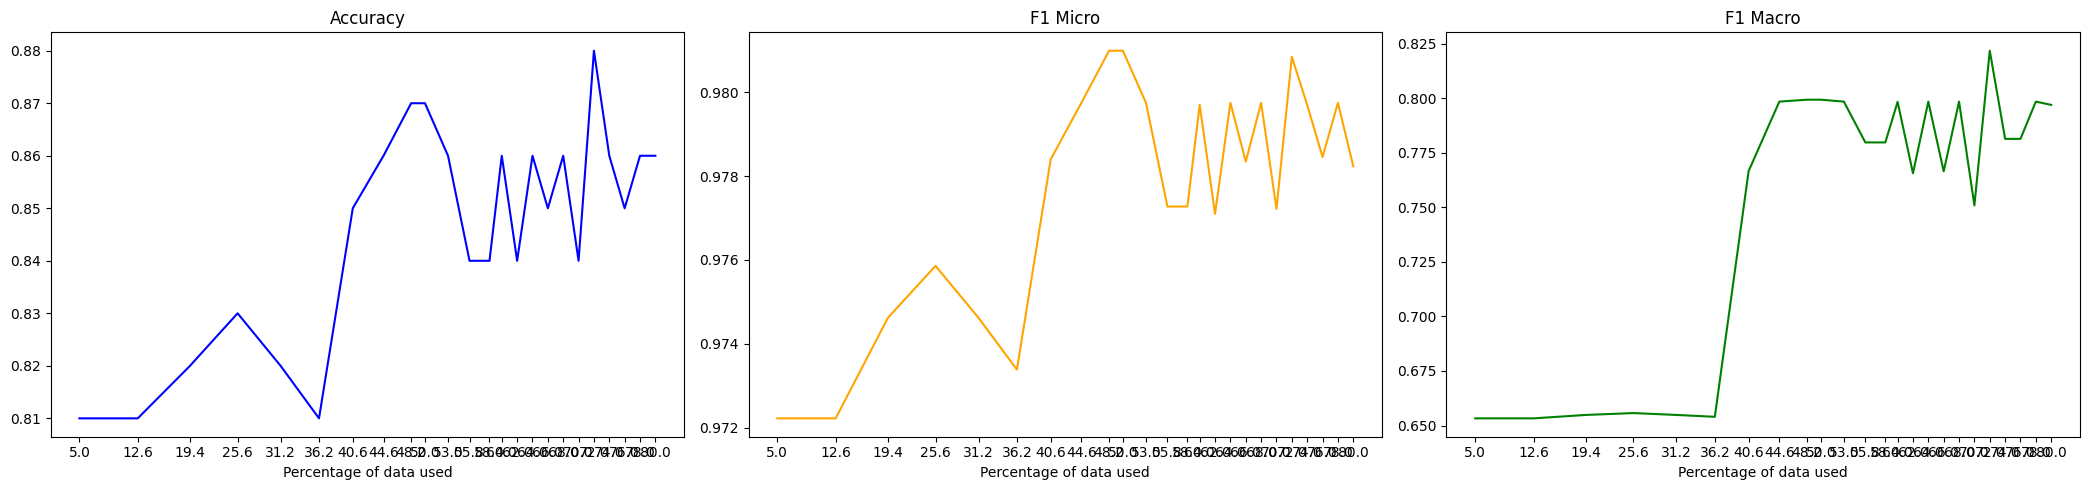

In [18]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.363988,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.269921,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.219893,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.200752,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.187067,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.179119,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.174042,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.171127,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.169264,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.168764,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.82947006225586
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.008227586746216 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.273245,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.192148,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.167708,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.156870,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.150692,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.148195,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.145501,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.143092,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.142658,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.142288,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.380208587646484
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7571918964385986 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.205908,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.163169,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.153852,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.149040,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.143956,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.140771,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.136303,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.139436,0.820000,0.964912,0.982143,0.973451,0.654117
9,No log,0.134167,0.820000,0.964912,0.982143,0.973451,0.654117
10,No log,0.135329,0.820000,0.964912,0.982143,0.973451,0.654117


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.82, F1 Micro: 0.9734513274336283, F1 Macro: 0.6541174340169316
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.970298957824708
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.4899368286132812 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.188867,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.156342,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.152377,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.141869,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.149743,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.133971,0.820000,0.964912,0.982143,0.973451,0.654117
7,No log,0.131469,0.820000,0.964912,0.982143,0.973451,0.654117
8,No log,0.127744,0.820000,0.974425,0.971939,0.973180,0.653588
9,No log,0.126760,0.790000,0.962312,0.977041,0.969620,0.652168
10,No log,0.127997,0.800000,0.962406,0.979592,0.970923,0.707723


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.82, F1 Micro: 0.9734513274336283, F1 Macro: 0.6541174340169316
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.646185588836671
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.2789716720581055 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.175281,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.156838,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.141376,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.137354,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.129113,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.119691,0.840000,0.965087,0.987245,0.976040,0.765229
7,No log,0.114107,0.830000,0.962687,0.987245,0.974811,0.749356
8,No log,0.112401,0.830000,0.962687,0.987245,0.974811,0.749356
9,No log,0.112596,0.830000,0.962687,0.987245,0.974811,0.749356
10,No log,0.111674,0.830000,0.962687,0.987245,0.974811,0.749356


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.96      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.84, F1 Micro: 0.9760403530895334, F1 Macro: 0.7652285451280426
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.96      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.302616786956788
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.0839474201202393 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.169193,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.151790,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.141551,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.129733,0.820000,0.958025,0.989796,0.973651,0.754117
5,No log,0.112901,0.840000,0.962779,0.989796,0.976101,0.779117
6,No log,0.110856,0.850000,0.969925,0.987245,0.978508,0.780700
7,No log,0.106802,0.860000,0.970000,0.989796,0.979798,0.803848
8,No log,0.105751,0.870000,0.972431,0.989796,0.981037,0.804718
9,No log,0.104430,0.860000,0.972362,0.987245,0.979747,0.803735
10,No log,0.106594,0.860000,0.972362,0.987245,0.979747,0.803735


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.8047180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.011937141418457
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.8714168071746826 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.168533,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.159134,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.155506,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.129024,0.810000,0.953431,0.992347,0.972500,0.764395
5,No log,0.112141,0.820000,0.958025,0.989796,0.973651,0.754117
6,No log,0.108640,0.820000,0.962687,0.987245,0.974811,0.746609
7,No log,0.106931,0.820000,0.960396,0.989796,0.974874,0.765951
8,No log,0.101130,0.850000,0.969925,0.987245,0.978508,0.767681
9,No log,0.107119,0.840000,0.965174,0.989796,0.977330,0.767681
10,No log,0.104016,0.840000,0.965174,0.989796,0.977330,0.767681


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.936778259277343
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7329752445220947 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.164441,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.151967,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133040,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.116050,0.830000,0.962687,0.987245,0.974811,0.764395
5,No log,0.107764,0.840000,0.962779,0.989796,0.976101,0.779117
6,No log,0.104863,0.850000,0.965261,0.992347,0.978616,0.789144
7,No log,0.103794,0.870000,0.974811,0.987245,0.980989,0.790688
8,No log,0.098894,0.870000,0.972431,0.989796,0.981037,0.804718
9,No log,0.098896,0.860000,0.977157,0.982143,0.979644,0.803501
10,No log,0.099051,0.880000,0.977273,0.987245,0.982234,0.805503


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.79      0.83      0.81       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.88, F1 Micro: 0.9822335025380711, F1 Macro: 0.8055027176056049
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.79      0.83      0.81       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 10.798237991333007
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.6574299335479736 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.174583,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.151460,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.140950,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.132477,0.830000,0.965000,0.984694,0.974747,0.720784
5,No log,0.103961,0.850000,0.965174,0.989796,0.977330,0.796975
6,No log,0.109139,0.850000,0.965174,0.989796,0.977330,0.796975
7,No log,0.096264,0.860000,0.972362,0.987245,0.979747,0.798557
8,No log,0.095105,0.870000,0.977215,0.984694,0.980940,0.782355
9,No log,0.096396,0.870000,0.974811,0.987245,0.980989,0.790688
10,No log,0.096461,0.880000,0.974874,0.989796,0.982278,0.791672


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.88, F1 Micro: 0.9822784810126581, F1 Macro: 0.7916718423578567
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.231420707702638
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.5286180973052979 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.157229,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142205,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131413,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.116940,0.820000,0.960298,0.987245,0.973585,0.748522
5,No log,0.116018,0.810000,0.953431,0.992347,0.972500,0.756682
6,No log,0.111899,0.850000,0.965261,0.992347,0.978616,0.760986
7,No log,0.099523,0.850000,0.969925,0.987245,0.978508,0.767681
8,No log,0.098133,0.840000,0.974619,0.979592,0.977099,0.766464
9,No log,0.098012,0.860000,0.974747,0.984694,0.979695,0.768466
10,No log,0.101059,0.870000,0.974811,0.987245,0.980989,0.790688


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7906879027907902
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.530037021636963
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4238917827606201 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153138,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.148053,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132062,0.820000,0.962594,0.984694,0.973518,0.719951
4,No log,0.110763,0.840000,0.965087,0.987245,0.976040,0.765229
5,No log,0.116677,0.820000,0.955774,0.992347,0.973717,0.765229
6,No log,0.101080,0.850000,0.972292,0.984694,0.978454,0.780587
7,No log,0.099344,0.860000,0.977157,0.982143,0.979644,0.768369
8,No log,0.101140,0.830000,0.965087,0.987245,0.976040,0.775930
9,No log,0.106900,0.850000,0.969925,0.987245,0.978508,0.777678
10,No log,0.101895,0.860000,0.972362,0.987245,0.979747,0.778567


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7785666906695781
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.270505714416505
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.2732257843017578 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154309,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142362,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125397,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.111319,0.830000,0.962687,0.987245,0.974811,0.764395
5,No log,0.111450,0.810000,0.953431,0.992347,0.972500,0.756682
6,No log,0.104529,0.840000,0.972152,0.979592,0.975858,0.755353
7,No log,0.107256,0.830000,0.962779,0.989796,0.976101,0.755811
8,No log,0.108360,0.840000,0.969773,0.982143,0.975919,0.758815
9,No log,0.101801,0.870000,0.974811,0.987245,0.980989,0.779466
10,No log,0.104004,0.860000,0.972362,0.987245,0.979747,0.778567


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7794655093650068
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.257490158081055
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.2196519374847412 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152125,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136482,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125798,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.121771,0.840000,0.972152,0.979592,0.975858,0.766343
5,No log,0.112201,0.840000,0.960494,0.992347,0.976161,0.776172
6,No log,0.101605,0.860000,0.977099,0.979592,0.978344,0.788565
7,No log,0.098020,0.870000,0.977215,0.984694,0.980940,0.790591
8,No log,0.102325,0.880000,0.974874,0.989796,0.982278,0.791672
9,No log,0.099549,0.870000,0.974811,0.987245,0.980989,0.790688
10,No log,0.102999,0.870000,0.974811,0.987245,0.980989,0.790688


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.88, F1 Micro: 0.9822784810126581, F1 Macro: 0.7916718423578567
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.531041240692138
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.1608781814575195 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155224,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142634,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113226,0.830000,0.962687,0.987245,0.974811,0.764395
4,No log,0.107188,0.840000,0.962779,0.989796,0.976101,0.779117
5,No log,0.106934,0.850000,0.962871,0.992347,0.977387,0.788293
6,No log,0.095940,0.850000,0.969925,0.987245,0.978508,0.788920
7,No log,0.098762,0.840000,0.967500,0.987245,0.977273,0.776799
8,No log,0.094329,0.860000,0.972362,0.987245,0.979747,0.803735
9,No log,0.101127,0.850000,0.969925,0.987245,0.978508,0.778567
10,No log,0.097609,0.860000,0.972362,0.987245,0.979747,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.8037352082157113
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.924269771575927
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.0933077335357666 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150499,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137763,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113993,0.830000,0.962687,0.987245,0.974811,0.764395
4,No log,0.103977,0.840000,0.962779,0.989796,0.976101,0.779117
5,No log,0.115138,0.810000,0.953431,0.992347,0.972500,0.756682
6,No log,0.107838,0.830000,0.962779,0.989796,0.976101,0.776912
7,No log,0.108912,0.850000,0.969925,0.987245,0.978508,0.760817
8,No log,0.111208,0.810000,0.955665,0.989796,0.972431,0.765101
9,No log,0.102030,0.850000,0.972292,0.984694,0.978454,0.778470
10,No log,0.103652,0.840000,0.969849,0.984694,0.977215,0.768369


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.44      1.00      0.62         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7608174907169882
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.44      1.00      0.62         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.924008750915528
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.0318098068237305 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150193,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134429,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123439,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.101429,0.850000,0.965174,0.989796,0.977330,0.796975
5,No log,0.099573,0.860000,0.967581,0.989796,0.978562,0.797817
6,No log,0.098054,0.860000,0.974747,0.984694,0.979695,0.798444
7,No log,0.104490,0.840000,0.969849,0.984694,0.977215,0.767471
8,No log,0.097397,0.880000,0.979695,0.984694,0.982188,0.805406
9,No log,0.100798,0.860000,0.974747,0.984694,0.979695,0.789693
10,No log,0.101561,0.860000,0.974747,0.984694,0.979695,0.789693


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.79      0.83      0.81       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.88, F1 Micro: 0.9821882951653944, F1 Macro: 0.8054058653053627
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.79      0.83      0.81       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.092137813568115
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.9940214157104492 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150847,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134277,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.120122,0.830000,0.965000,0.984694,0.974747,0.720784
4,No log,0.106233,0.850000,0.965174,0.989796,0.977330,0.796975
5,No log,0.106591,0.830000,0.976923,0.971939,0.974425,0.785437
6,No log,0.105167,0.850000,0.962871,0.992347,0.977387,0.788293
7,No log,0.102790,0.850000,0.969849,0.984694,0.977215,0.776683
8,No log,0.100655,0.860000,0.972292,0.984694,0.978454,0.788805
9,No log,0.102412,0.850000,0.969849,0.984694,0.977215,0.776683
10,No log,0.105302,0.840000,0.967419,0.984694,0.975980,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7888046636194153
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.911982154846191
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.8571479320526123 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145626,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130287,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112707,0.840000,0.965087,0.987245,0.976040,0.765229
4,No log,0.105794,0.840000,0.972152,0.979592,0.975858,0.765577
5,No log,0.099320,0.860000,0.972292,0.984694,0.978454,0.797575
6,No log,0.108124,0.830000,0.965000,0.984694,0.974747,0.758035
7,No log,0.107825,0.840000,0.965087,0.987245,0.976040,0.755700
8,No log,0.106854,0.840000,0.967419,0.984694,0.975980,0.755587
9,No log,0.112737,0.820000,0.960298,0.987245,0.973585,0.750825
10,No log,0.110246,0.840000,0.965087,0.987245,0.976040,0.766698


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.797575177474675
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.761019420623779
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.7870049476623535 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143544,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133150,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118394,0.830000,0.965000,0.984694,0.974747,0.720784
4,No log,0.097286,0.860000,0.969925,0.987245,0.978508,0.797697
5,No log,0.098142,0.850000,0.967581,0.989796,0.978562,0.777782
6,No log,0.100583,0.860000,0.967581,0.989796,0.978562,0.777782
7,No log,0.103160,0.850000,0.969925,0.987245,0.978508,0.768466
8,No log,0.098645,0.850000,0.972292,0.984694,0.978454,0.777572
9,No log,0.096991,0.840000,0.972222,0.982143,0.977157,0.776565
10,No log,0.103198,0.850000,0.967500,0.987245,0.977273,0.767577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7777820076815053
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.311989974975585
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7128548622131348 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147027,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141627,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115721,0.840000,0.967419,0.984694,0.975980,0.711366
4,No log,0.103357,0.840000,0.976982,0.974490,0.975734,0.778305
5,No log,0.099631,0.860000,0.979540,0.977041,0.978289,0.780232
6,No log,0.098853,0.860000,0.979540,0.977041,0.978289,0.780232
7,No log,0.102757,0.850000,0.969849,0.984694,0.977215,0.767471
8,No log,0.100654,0.870000,0.974747,0.984694,0.979695,0.789693
9,No log,0.098284,0.860000,0.979540,0.977041,0.978289,0.780232
10,No log,0.100188,0.860000,0.972292,0.984694,0.978454,0.788805


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7896927820922796
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 10.634808540344238
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6208350658416748 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142785,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127349,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111032,0.820000,0.962594,0.984694,0.973518,0.738920
4,No log,0.104177,0.850000,0.967500,0.987245,0.977273,0.776799
5,No log,0.096657,0.870000,0.977157,0.982143,0.979644,0.752593
6,No log,0.101245,0.860000,0.969925,0.987245,0.978508,0.777678
7,No log,0.102261,0.860000,0.970000,0.989796,0.979798,0.778661
8,No log,0.102196,0.870000,0.972431,0.989796,0.981037,0.779551
9,No log,0.104758,0.830000,0.972081,0.977041,0.974555,0.765312
10,No log,0.106570,0.830000,0.967419,0.984694,0.975980,0.767471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7795506302366446
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.369877529144286
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5137741565704346 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141436,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132879,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111291,0.830000,0.972081,0.977041,0.974555,0.729427
4,No log,0.105558,0.820000,0.964912,0.982143,0.973451,0.764699
5,No log,0.101397,0.830000,0.967337,0.982143,0.974684,0.754593
6,No log,0.103128,0.840000,0.976982,0.974490,0.975734,0.765312
7,No log,0.112595,0.820000,0.969620,0.977041,0.973316,0.756765
8,No log,0.108472,0.840000,0.967500,0.987245,0.977273,0.776799
9,No log,0.108232,0.820000,0.967337,0.982143,0.974684,0.774800
10,No log,0.108246,0.820000,0.967337,0.982143,0.974684,0.774800


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.84, F1 Micro: 0.9772727272727273, F1 Macro: 0.7767991812796843
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.097987461090089
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.470447301864624 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141613,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128855,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.105106,0.850000,0.967500,0.987245,0.977273,0.766071
4,No log,0.103433,0.860000,0.969925,0.987245,0.978508,0.788920
5,No log,0.113786,0.840000,0.965087,0.987245,0.976040,0.759030
6,No log,0.092488,0.870000,0.977157,0.982143,0.979644,0.798328
7,No log,0.096428,0.850000,0.969849,0.984694,0.977215,0.767471
8,No log,0.098302,0.830000,0.969697,0.979592,0.974619,0.766343
9,No log,0.099330,0.840000,0.972152,0.979592,0.975858,0.766343
10,No log,0.099316,0.830000,0.967419,0.984694,0.975980,0.767471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.87, F1 Micro: 0.9796437659033078, F1 Macro: 0.7983284731432249
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.27647590637207
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.3712000846862793 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141537,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133573,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.114015,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.100768,0.860000,0.972292,0.984694,0.978454,0.780587
5,No log,0.097496,0.840000,0.974555,0.977041,0.975796,0.778448
6,No log,0.096827,0.840000,0.972152,0.979592,0.975858,0.755353
7,No log,0.102395,0.840000,0.972222,0.982143,0.977157,0.776565
8,No log,0.104716,0.850000,0.972292,0.984694,0.978454,0.777572
9,No log,0.108034,0.830000,0.967419,0.984694,0.975980,0.775805
10,0.101200,0.105508,0.830000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392

Total sampling time: 31.94 seconds
Total runtime: 2702.825835943222 seconds


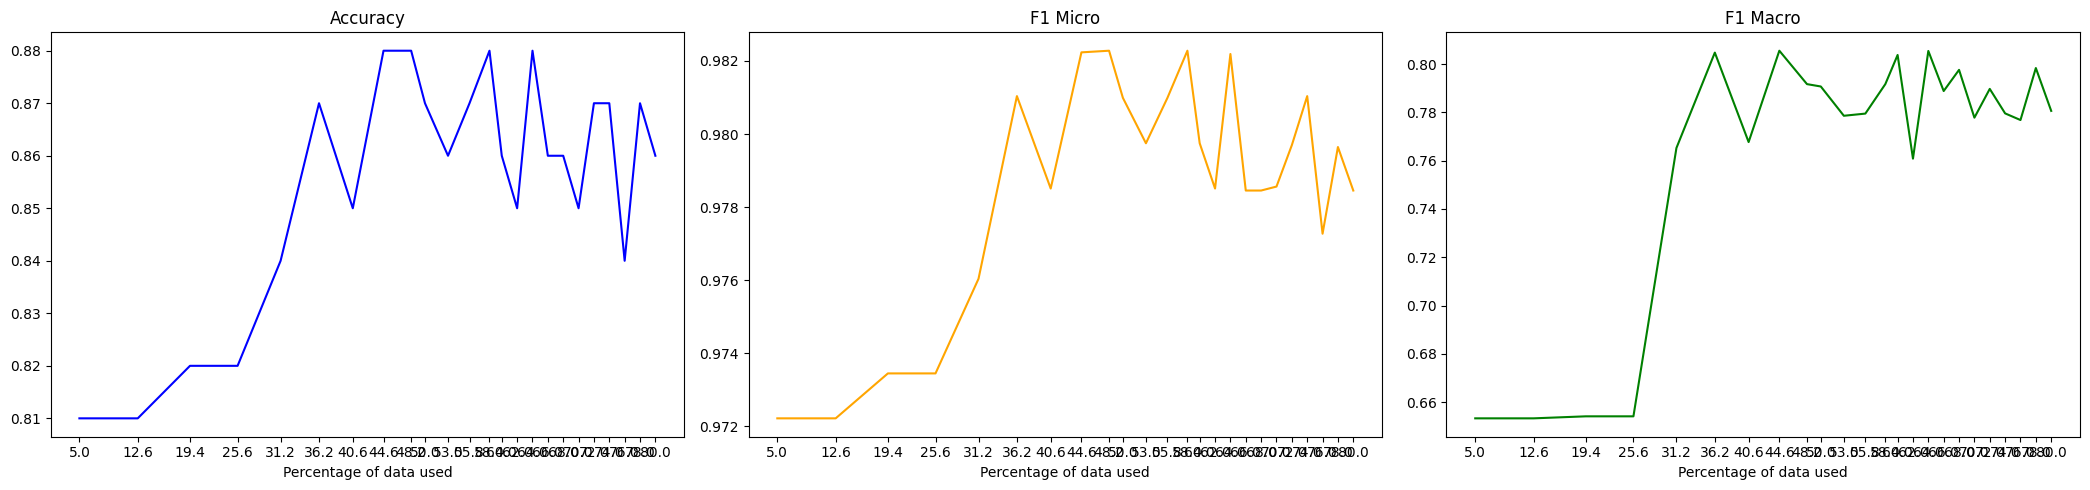

In [19]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.380765,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.275398,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.239973,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.220720,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.202465,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.190056,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.182793,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.178994,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.177267,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.177220,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.069991302490235
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 2.9555206298828125 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.291739,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.193259,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.164091,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.154558,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.148059,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.143759,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.140570,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.138932,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.138252,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.138125,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.13198356628418
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7130298614501953 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.217122,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.160880,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.148515,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.141667,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.138865,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.133079,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.131481,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.131161,0.810000,0.964912,0.982143,0.973451,0.654117
9,No log,0.129932,0.810000,0.964912,0.982143,0.973451,0.654117
10,No log,0.131609,0.810000,0.964912,0.982143,0.973451,0.654117


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9734513274336283, F1 Macro: 0.6541174340169316
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.511582183837891
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.5053622722625732 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.192043,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.156301,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143517,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.141768,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.135161,0.810000,0.964912,0.982143,0.973451,0.654117
6,No log,0.131663,0.810000,0.964912,0.982143,0.973451,0.654117
7,No log,0.126816,0.810000,0.967172,0.977041,0.972081,0.653009
8,No log,0.125890,0.810000,0.964912,0.982143,0.973451,0.654117
9,No log,0.125878,0.830000,0.972081,0.977041,0.974555,0.654718
10,No log,0.124896,0.820000,0.969620,0.977041,0.973316,0.653859


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9745547073791349, F1 Macro: 0.6547180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.151252365112304
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.29606032371521 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.174634,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147847,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.139361,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136473,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.127391,0.810000,0.964912,0.982143,0.973451,0.654117
6,No log,0.130216,0.810000,0.964912,0.982143,0.973451,0.654117
7,No log,0.130125,0.810000,0.964912,0.982143,0.973451,0.654117
8,No log,0.124783,0.820000,0.967337,0.982143,0.974684,0.654960
9,No log,0.121907,0.810000,0.974359,0.969388,0.971867,0.652572
10,No log,0.120587,0.790000,0.969388,0.969388,0.969388,0.650848


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.82, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.946853733062746
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.0844061374664307 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.168144,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.149252,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.139910,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.131000,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.130088,0.810000,0.964912,0.982143,0.973451,0.654117
6,No log,0.119988,0.850000,0.974619,0.979592,0.977099,0.656570
7,No log,0.112325,0.840000,0.974555,0.977041,0.975796,0.721260
8,No log,0.109472,0.860000,0.972362,0.987245,0.979747,0.767783
9,No log,0.107462,0.860000,0.974684,0.982143,0.978399,0.766698
10,No log,0.107217,0.850000,0.974619,0.979592,0.977099,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7677827476822451
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.09607563018799
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.8874974250793457 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.165439,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.148453,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135118,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.130117,0.810000,0.964912,0.982143,0.973451,0.654117
5,No log,0.127946,0.820000,0.967254,0.979592,0.973384,0.653989
6,No log,0.116976,0.820000,0.962687,0.987245,0.974811,0.749356
7,No log,0.110600,0.840000,0.967500,0.987245,0.977273,0.766071
8,No log,0.108953,0.850000,0.974619,0.979592,0.977099,0.765704
9,No log,0.107888,0.840000,0.972222,0.982143,0.977157,0.750825
10,No log,0.108244,0.840000,0.972152,0.979592,0.975858,0.749831


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.84, F1 Micro: 0.9772727272727273, F1 Macro: 0.766070691622363
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 12.183319473266602
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7198355197906494 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.160123,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145767,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134148,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.129289,0.810000,0.964912,0.982143,0.973451,0.654117
5,No log,0.113015,0.820000,0.962687,0.987245,0.974811,0.749356
6,No log,0.115033,0.840000,0.965174,0.989796,0.977330,0.767681
7,No log,0.108602,0.820000,0.962687,0.987245,0.974811,0.746609
8,No log,0.104518,0.850000,0.969925,0.987245,0.978508,0.767681
9,No log,0.106363,0.840000,0.967500,0.987245,0.977273,0.766811
10,No log,0.107371,0.830000,0.965087,0.987245,0.976040,0.755700


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.579025840759277
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.5968904495239258 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154367,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141313,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133563,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123862,0.810000,0.964912,0.982143,0.973451,0.654117
5,No log,0.109070,0.870000,0.974811,0.987245,0.980989,0.768653
6,No log,0.104934,0.870000,0.972431,0.989796,0.981037,0.782542
7,No log,0.103640,0.860000,0.974747,0.984694,0.979695,0.798444
8,No log,0.104500,0.870000,0.972431,0.989796,0.981037,0.782542
9,No log,0.101656,0.860000,0.972362,0.987245,0.979747,0.781570
10,No log,0.101814,0.870000,0.974811,0.987245,0.980989,0.799427


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7825418529109637
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 11.153576278686524
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.5657715797424316 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148083,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139174,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128363,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.129440,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.115198,0.850000,0.974684,0.982143,0.978399,0.657542
6,No log,0.108336,0.870000,0.972431,0.989796,0.981037,0.782542
7,No log,0.108020,0.870000,0.972431,0.989796,0.981037,0.782542
8,No log,0.106180,0.850000,0.972292,0.984694,0.978454,0.780587
9,No log,0.105040,0.820000,0.965000,0.984694,0.974747,0.746496
10,No log,0.105058,0.830000,0.967419,0.984694,0.975980,0.755587


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7825418529109637
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 10.908705615997315
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4304368495941162 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153873,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143429,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132883,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.124687,0.830000,0.969773,0.982143,0.975919,0.655811
5,No log,0.115401,0.810000,0.958025,0.989796,0.973651,0.750938
6,No log,0.108032,0.820000,0.965000,0.984694,0.974747,0.746496
7,No log,0.102722,0.840000,0.969849,0.984694,0.977215,0.756466
8,No log,0.103520,0.810000,0.967254,0.979592,0.973384,0.745375
9,No log,0.102555,0.820000,0.967337,0.982143,0.974684,0.746380
10,No log,0.101726,0.810000,0.967254,0.979592,0.973384,0.745375


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.84, F1 Micro: 0.9772151898734177, F1 Macro: 0.7564658498484934
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 11.391179084777832
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.4159188270568848 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150401,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141966,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126200,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.112036,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.107978,0.850000,0.965174,0.989796,0.977330,0.796975
6,No log,0.100281,0.860000,0.974747,0.984694,0.979695,0.798444
7,No log,0.100846,0.850000,0.974684,0.982143,0.978399,0.780471
8,No log,0.100571,0.860000,0.974747,0.984694,0.979695,0.781466
9,No log,0.102050,0.830000,0.972152,0.979592,0.975858,0.765577
10,No log,0.102983,0.830000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 11.006758689880371
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.266388177871704 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150026,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141148,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129480,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.113089,0.810000,0.964912,0.982143,0.973451,0.654117
5,No log,0.105092,0.840000,0.974619,0.979592,0.977099,0.656570
6,No log,0.100999,0.840000,0.969849,0.984694,0.977215,0.739903
7,No log,0.099794,0.830000,0.969773,0.982143,0.975919,0.755471
8,No log,0.099814,0.850000,0.967581,0.989796,0.978562,0.757542
9,No log,0.102811,0.830000,0.965087,0.987245,0.976040,0.740783
10,No log,0.099845,0.840000,0.967500,0.987245,0.977273,0.748358


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7575418529109638
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 11.055754661560059
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.1807034015655518 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144933,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145013,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123671,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115207,0.830000,0.965087,0.987245,0.976040,0.739144
5,No log,0.113664,0.820000,0.960396,0.989796,0.974874,0.740005
6,No log,0.100124,0.850000,0.974684,0.982143,0.978399,0.751704
7,No log,0.104235,0.810000,0.964912,0.982143,0.973451,0.738805
8,No log,0.103802,0.810000,0.964912,0.982143,0.973451,0.738805
9,No log,0.102031,0.830000,0.965087,0.987245,0.976040,0.740783
10,No log,0.104245,0.830000,0.965087,0.987245,0.976040,0.759030


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.75      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7517039450865887
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.75      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.450860595703125
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.0386641025543213 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153506,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132716,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121522,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.109747,0.860000,0.974747,0.984694,0.979695,0.767681
5,No log,0.100711,0.870000,0.977215,0.984694,0.980940,0.768560
6,No log,0.102907,0.840000,0.967500,0.987245,0.977273,0.748358
7,No log,0.102701,0.830000,0.969773,0.982143,0.975919,0.747269
8,No log,0.102346,0.830000,0.972152,0.979592,0.975858,0.755353
9,No log,0.103690,0.840000,0.969849,0.984694,0.977215,0.748264
10,No log,0.102488,0.830000,0.969773,0.982143,0.975919,0.747269


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.87, F1 Micro: 0.9809402795425667, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 9.88840980529785
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.036179542541504 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147601,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133586,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134671,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.124882,0.830000,0.960396,0.989796,0.974874,0.765229
5,No log,0.112349,0.810000,0.964912,0.982143,0.973451,0.745502
6,No log,0.101269,0.820000,0.962687,0.987245,0.974811,0.739903
7,No log,0.100950,0.810000,0.962594,0.984694,0.973518,0.738920
8,No log,0.104744,0.810000,0.964912,0.982143,0.973451,0.738805
9,No log,0.099678,0.830000,0.969773,0.982143,0.975919,0.755471
10,No log,0.101913,0.810000,0.964912,0.982143,0.973451,0.738805


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.83, F1 Micro: 0.9759188846641319, F1 Macro: 0.755471330286082
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.50297441482544
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.9623744487762451 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145020,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135453,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117348,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.108287,0.850000,0.974684,0.982143,0.978399,0.723237
5,No log,0.111994,0.850000,0.967581,0.989796,0.978562,0.768560
6,No log,0.106766,0.850000,0.967581,0.989796,0.978562,0.768560
7,No log,0.105082,0.850000,0.969925,0.987245,0.978508,0.768466
8,No log,0.108377,0.830000,0.967419,0.984694,0.975980,0.758924
9,No log,0.105834,0.840000,0.967500,0.987245,0.977273,0.759919
10,No log,0.105374,0.840000,0.967500,0.987245,0.977273,0.759919


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.16896095275879
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.8644404411315918 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141713,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133695,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121316,0.840000,0.974619,0.979592,0.977099,0.656570
4,No log,0.106165,0.840000,0.974619,0.979592,0.977099,0.656570
5,No log,0.100549,0.840000,0.976982,0.974490,0.975734,0.764559
6,No log,0.102497,0.840000,0.972222,0.982143,0.977157,0.756359
7,No log,0.100709,0.860000,0.979592,0.979592,0.979592,0.767471
8,No log,0.101840,0.850000,0.974684,0.982143,0.978399,0.767471
9,No log,0.103961,0.850000,0.969925,0.987245,0.978508,0.757449
10,No log,0.103998,0.840000,0.972222,0.982143,0.977157,0.756359


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.9795918367346939, F1 Macro: 0.7674705598700573
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 10.154751682281494
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.8277797698974609 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148711,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130782,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121005,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.113289,0.810000,0.955665,0.989796,0.972431,0.745027
5,No log,0.100434,0.870000,0.974811,0.987245,0.980989,0.782449
6,No log,0.112476,0.830000,0.960396,0.989796,0.974874,0.746720
7,No log,0.097906,0.850000,0.972222,0.982143,0.977157,0.756359
8,No log,0.097263,0.850000,0.972292,0.984694,0.978454,0.767577
9,No log,0.100524,0.830000,0.965087,0.987245,0.976040,0.759030
10,No log,0.101091,0.830000,0.965087,0.987245,0.976040,0.759030


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7824492574604868
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 10.147279262542725
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7237722873687744 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141128,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.124204,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118783,0.830000,0.969697,0.979592,0.974619,0.654840
4,No log,0.102555,0.830000,0.976923,0.971939,0.974425,0.654466
5,No log,0.107686,0.850000,0.969849,0.984694,0.977215,0.767471
6,No log,0.100883,0.840000,0.972222,0.982143,0.977157,0.739799
7,No log,0.107896,0.830000,0.965087,0.987245,0.976040,0.759030
8,No log,0.107376,0.830000,0.965087,0.987245,0.976040,0.759030
9,No log,0.103799,0.830000,0.965087,0.987245,0.976040,0.759030
10,No log,0.104468,0.840000,0.967500,0.987245,0.977273,0.767577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.84, F1 Micro: 0.9772727272727273, F1 Macro: 0.7675769609596045
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.44106683731079
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6384789943695068 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139490,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137206,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115896,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.103764,0.840000,0.969849,0.984694,0.977215,0.756466
5,No log,0.100400,0.820000,0.974425,0.971939,0.973180,0.763374
6,No log,0.097530,0.830000,0.974490,0.974490,0.974490,0.777419
7,No log,0.106559,0.820000,0.965000,0.984694,0.974747,0.758035
8,No log,0.104079,0.810000,0.964912,0.982143,0.973451,0.757030
9,No log,0.103716,0.810000,0.967254,0.979592,0.973384,0.756899
10,No log,0.103254,0.830000,0.967419,0.984694,0.975980,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.84, F1 Micro: 0.9772151898734177, F1 Macro: 0.7564658498484934
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.861818027496339
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5705149173736572 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138424,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127934,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.105631,0.830000,0.969697,0.979592,0.974619,0.654840
4,No log,0.102897,0.820000,0.967254,0.979592,0.973384,0.745375
5,No log,0.100392,0.840000,0.969849,0.984694,0.977215,0.756466
6,No log,0.101364,0.850000,0.969925,0.987245,0.978508,0.757449
7,No log,0.107262,0.810000,0.967254,0.979592,0.973384,0.756899
8,No log,0.095626,0.840000,0.969849,0.984694,0.977215,0.776683
9,No log,0.098893,0.830000,0.965087,0.987245,0.976040,0.759030
10,No log,0.096798,0.820000,0.965000,0.984694,0.974747,0.758035


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7574492574604869
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 8.857021141052247
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.49596667289733887 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147990,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128472,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.114832,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.101475,0.810000,0.979275,0.964286,0.971722,0.652263
5,No log,0.099946,0.860000,0.977099,0.979592,0.978344,0.797323
6,No log,0.100858,0.820000,0.967254,0.979592,0.973384,0.745375
7,No log,0.107892,0.820000,0.962687,0.987245,0.974811,0.739903
8,No log,0.098238,0.850000,0.974684,0.982143,0.978399,0.757258
9,No log,0.098629,0.860000,0.977157,0.982143,0.979644,0.768369
10,No log,0.100964,0.830000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.86, F1 Micro: 0.9796437659033078, F1 Macro: 0.7683688282683256
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 8.840609073638916
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.3940248489379883 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.136278,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.123478,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125374,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.096559,0.850000,0.974684,0.982143,0.978399,0.780471
5,No log,0.108748,0.810000,0.967172,0.977041,0.972081,0.755869
6,No log,0.098697,0.860000,0.969925,0.987245,0.978508,0.777678
7,No log,0.106926,0.840000,0.967419,0.984694,0.975980,0.766582
8,No log,0.102092,0.840000,0.967419,0.984694,0.975980,0.766582
9,No log,0.100358,0.840000,0.967419,0.984694,0.975980,0.766582
10,0.100100,0.102521,0.840000,0.967419,0.984694,0.975980,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.86, F1 Micro: 0.9785082174462705, F1 Macro: 0.7776779710606146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 32.17 seconds
Total runtime: 2709.9627277851105 seconds


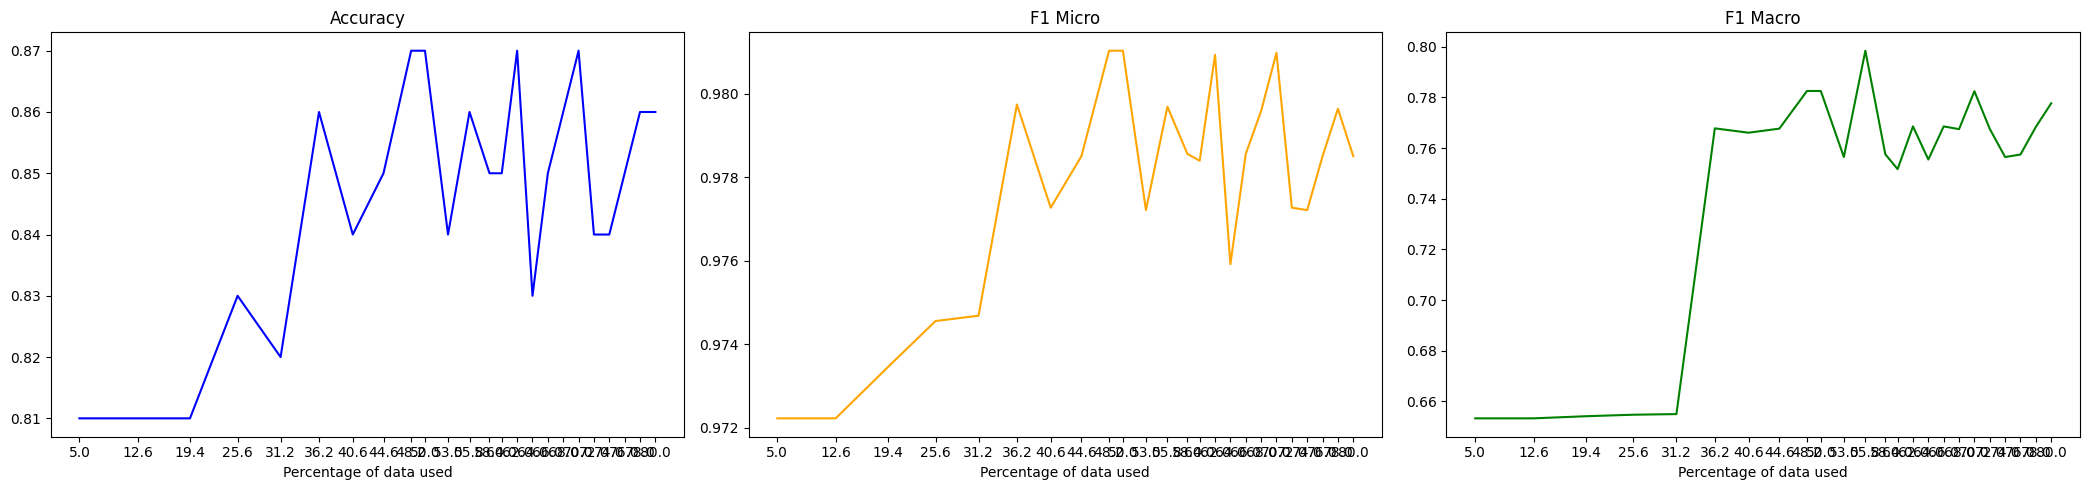

In [20]:
active_learning(seeds[4], 4)